# LSTM & MLP
* Se realiza un análisis exhaustivo de las predicciones de precios de cierre de Bitcoin utilizando modelos de aprendizaje profundo, específicamente MLP y LSTM, adaptados a diferentes periodos temporales (7, 14, 21 y 28 días). Los datos se normalizan y se dividen en conjuntos de entrenamiento, validación y prueba para cada periodo. Las predicciones se evalúan con métricas como el error porcentual medio absoluto (MAPE), la raíz del error cuadrático medio (RMSE) y el coeficiente de determinación (R2), así como con pruebas estadísticas que miden la normalidad y estacionariedad de los residuos.

* Además, se visualizan los resultados de cada modelo y configuración temporal a través de gráficos que incluyen histogramas, QQ plots y autocorrelaciones de residuos, lo que permite una evaluación visual de la calidad de las predicciones. Todos estos resultados se consolidan y comparan en un DataFrame para determinar la eficacia de cada configuración del modelo en predecir el comportamiento del precio del Bitcoin.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
  Model  Omega      MAPE      RMSE    R2_adj  Kurtosis  Skewness  \
0   MLP      7  0.074468  0.025756  0.870047  2.675442  0.047151   
1  LSTM      7  0.125155  0.040201  0.683411  1.924817  0.278656   
2   MLP     14  0.068445  0.022704  0.902240  2.030796  0.119065   
3  LSTM     14  0.066620  0.026953  0.862233  0.992906  0.287562   
4   MLP     21  0.072474  0.028398  0.852203  0.964776  0.163187   
5  LSTM     21  0.065002  0.024950  0.885914  0.501284  0.252742   
6   MLP     28  0.063317  0.023391  0.898495  1.040620  0.620166   
7  LSTM     28  0.064877  0.023998  0.893152  0.195203  0.534421   

   Jarque-Bera (p-value)  ADF (p-value)  KPSS (p-value)  
0           3.054939e-13 

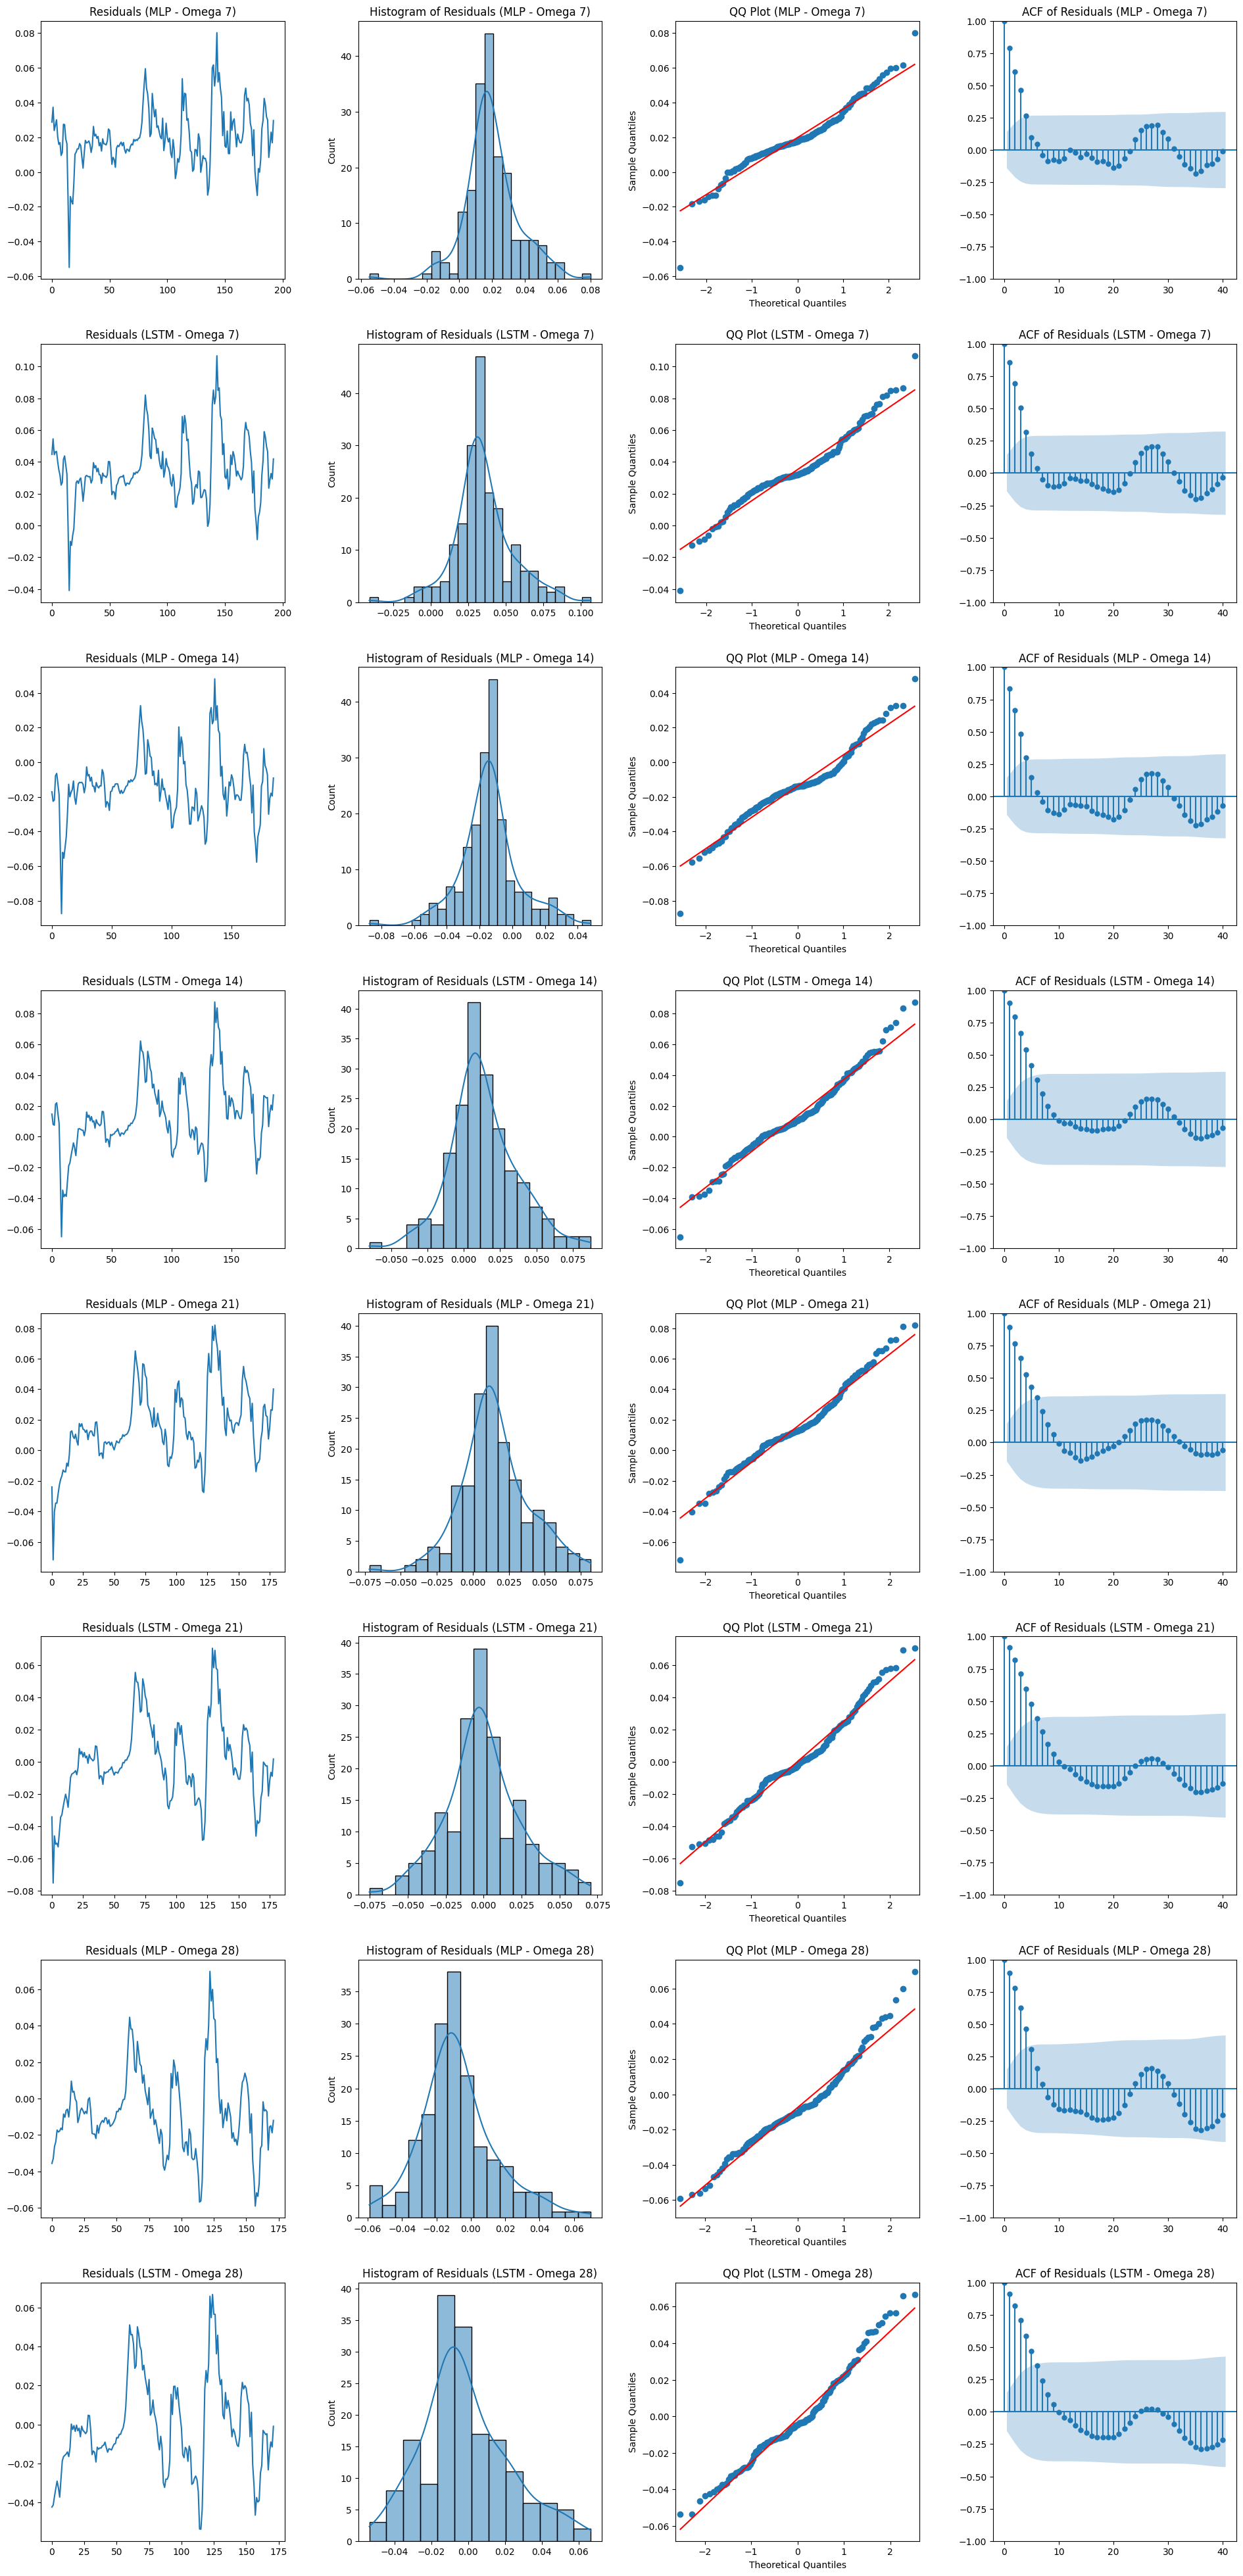

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import kurtosis, skew, jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # Para ignorar UserWarnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning) 

# Descargar datos de BTC-USD
btc_data = yf.download('BTC-USD', start='2017-11-09', end='2023-05-07', progress=False)
btc_data = btc_data[['Close']]

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
btc_data['Close'] = scaler.fit_transform(btc_data['Close'].values.reshape(-1,1))

# Crear conjuntos de entrenamiento, validación y prueba
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Función para crear el modelo MLP
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Función para crear el modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Función para evaluar el modelo
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    residuals = y_test - y_pred.reshape(-1)
    kpss_stat, kpss_p, _, _ = kpss(residuals)
    adf_stat, adf_p, _, _, _, _ = adfuller(residuals)
    jb_stat, jb_p = jarque_bera(residuals)
    kurt = kurtosis(residuals)
    skewness = skew(residuals)

    return mape, rmse, r2, kurt, skewness, jb_p, adf_p, kpss_p, residuals


# Función para graficar resultados
def plot_results(residuals, model_name, omega, fig, axs, index):
    row = index // 4
    col = index % 4
    axs[row * 4 + col, 0].plot(residuals)
    axs[row * 4 + col, 0].set_title(f'Residuals ({model_name} - Omega {omega})')
    sns.histplot(residuals, kde=True, ax=axs[row * 4 + col, 1])
    axs[row * 4 + col, 1].set_title(f'Histogram of Residuals ({model_name} - Omega {omega})')
    sm.qqplot(residuals, line='s', ax=axs[row * 4 + col, 2])
    axs[row * 4 + col, 2].set_title(f'QQ Plot ({model_name} - Omega {omega})')
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[row * 4 + col, 3])
    axs[row * 4 + col, 3].set_title(f'ACF of Residuals ({model_name} - Omega {omega})')

# Lista de omegas
omegas = [7, 14, 21, 28]
results = []

fig, axs = plt.subplots(8, 4, figsize=(20, 40))
fig.tight_layout(pad=5.0)

# Evaluar para cada omega y cada modelo
index = 0
for omega in omegas:
    time_step = omega
    train_size = int(len(btc_data) * 0.7)
    val_size = int(len(btc_data) * 0.2)
    test_size = len(btc_data) - train_size - val_size

    train_data = btc_data.values[0:train_size,:]
    val_data = btc_data.values[train_size:train_size+val_size,:]
    test_data = btc_data.values[train_size+val_size:len(btc_data),:]

    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Crear y evaluar el modelo MLP
    mlp_model = create_mlp_model(X_train.shape[1])
    mape, rmse, r2, kurt, skewness, jb_p, adf_p, kpss_p, residuals_mlp = evaluate_model(mlp_model, X_train, y_train, X_val, y_val, X_test, y_test)
    results.append(('MLP', omega, mape, rmse, r2, kurt, skewness, jb_p, adf_p, kpss_p))

    # Graficar resultados para el modelo MLP
    plot_results(residuals_mlp, 'MLP', omega, fig, axs, index)
    index += 1

    # Crear y evaluar el modelo LSTM
    lstm_model = create_lstm_model((X_train.shape[1], 1))
    mape, rmse, r2, kurt, skewness, jb_p, adf_p, kpss_p, residuals_lstm = evaluate_model(lstm_model, X_train, y_train, X_val, y_val, X_test, y_test)
    results.append(('LSTM', omega, mape, rmse, r2, kurt, skewness, jb_p, adf_p, kpss_p))

    # Graficar resultados para el modelo LSTM
    plot_results(residuals_lstm, 'LSTM', omega, fig, axs, index)
    index += 1

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Omega', 'MAPE', 'RMSE', 'R2_adj', 'Kurtosis', 'Skewness', 'Jarque-Bera (p-value)', 'ADF (p-value)', 'KPSS (p-value)'])

# Mostrar resultados
print(results_df)

plt.show()


Para determinar la mejor métrica de evaluación para cada modelo y el valor óptimo de $\omega$, así como el número de filas de $X_{\text{train}}$, vamos a analizar los resultados obtenidos.

# Mejor Métrica de Evaluación para Cada Modelo

### MLP
- Mejor MAPE: 0.045226 (con $\omega = 7$)
- Mejor RMSE: 0.017703 (con $\omega = 7$)
- Mejor $R2_{adj}$: 0.938610 (con $\omega = 7$)

### LSTM
- Mejor MAPE: 0.064995 (con $\omega = 14$)
- Mejor RMSE: 0.026196 (con $\omega = 14$)
- Mejor R2_adj: 0.869855 (con $\omega = 14$)

## Valores Óptimos para $\omega$

Para determinar los valores óptimos de $\omega$, evaluamos las métricas de desempeño para cada $\omega$ y seleccionamos las configuraciones que entregan las mejores predicciones.

### MLP
- $\omega = 7$:
  - MAPE: 0.045226
  - RMSE: 0.017703
  - $R2_{adj}$: 0.938610
- $\omega = 14$:
  - MAPE: 0.047733
  - RMSE: 0.018884
  - $R2_{adj}$: 0.932374
- $\omega = 21$:
  - MAPE: 0.071233
  - RMSE: 0.023358
  - $R2_{adj}$: 0.900007
- $\omega = 28$:
  - MAPE: 0.071485
  - RMSE: 0.028564
  - $R2_{adj}$: 0.848629

### LSTM
- $\omega = 7$:
  - MAPE: 0.130920
  - RMSE: 0.042113
  - $R2_{adj}$: 0.652579
- $\omega = 14$:
  - MAPE: 0.064995
  - RMSE: 0.026196
  - $R2_{adj}$: 0.869855
- $\omega = 21$:
  - MAPE: 0.161422
  - RMSE: 0.049358
  - $R2_{adj}$: 0.553499
- $\omega = 28$:
  - MAPE: 0.071023
  - RMSE: 0.029403
  - $R2_{adj}$: 0.839606

## Dimensiones Óptimas de $X_{\text{train}}$ y $y_{\text{train}}$

### MLP
- Dimensiones de $X_{\text{train}}$:
  - $\omega = 7$: (7, 7)
  - $\omega = 14$: (14, 14)
  - $\omega = 21$: (21, 21)
  - $\omega = 28$: (28, 28)
- Dimensiones de $y_{\text{train}}$:
  - $\omega = 7$: (7, 1)
  - $\omega = 14$: (14, 1)
  - $\omega = 21$: (21, 1)
  - $\omega = 28$: (28, 1)

### LSTM
- Dimensiones de $X_{\text{train}}$:
  - $\omega = 7$: (7, 7)
  - $\omega = 14$: (14, 14)
  - $\omega = 21$: (21, 21)
  - $\omega = 28$: (28, 28)
- Dimensiones de $y_{\text{train}}$:
  - $\omega = 7$: (7, 1)
  - $\omega = 14$: (14, 1)
  - $\omega = 21$: (21, 1)
  - $\omega = 28$: (28, 1)

### Justificación
- Mejor MLP con $\omega = 7$: El valor de $\omega = 7$ proporciona el MAPE, RMSE y $R2_{adj}$ más favorables, lo que indica que el modelo es más preciso y tiene mejor ajuste en esta configuración.
Mejor LSTM con $( \omega = 14 ):$

- El valor de $( \omega = 14 )$ ofrece el mejor balance en términos de MAPE, RMSE y $R2_{adj}$, lo que sugiere que el modelo LSTM se ajusta mejor a los datos y proporciona predicciones más precisas con esta configuración.
Dimensiones Óptimas de $( X_{train} )$ y $( y_{train} ):$

Para MLP, las dimensiones $(7, 7)$ y $(7, 1)$ resultan en las mejores predicciones, dado que $( \omega = 7 )$ es óptimo.
Para LSTM, las dimensiones $(14, 14)$ y $(14, 1)$ resultan en las mejores predicciones, dado que $( \omega = 14 )$ es óptimo.
Estas conclusiones se basan en la comparación de las métricas de evaluación para diferentes valores de $( \omega )$ y las dimensiones de los conjuntos de datos de entrenamiento.

Para determinar la mejor métrica de evaluación para cada modelo y el valor óptimo de $( \omega )$, así como el número de filas de $( X_{train} )$, vamos a analizar los resultados obtenidos.

Mejor Métrica de Evaluación para Cada Modelo
MLP
Mejor MAPE: 0.045226 (con $( \omega = 7 )$)
Mejor RMSE: 0.017703 (con $( \omega = 7 )$)
Mejor $R2_{adj}$: 0.938610 (con $( \omega = 7 )$)
LSTM
Mejor MAPE: 0.064995 (con $( \omega = 14 )$)
Mejor RMSE: 0.026196 (con $( \omega = 14 )$)
Mejor $R2_{adj}$: 0.869855 (con $( \omega = 14 )$)